# Warm little pond model

This based on the model developed by Ben K. D. Pearce et al. in the following publications:

- Pearce, B. K., Pudritz, R. E., Semenov, D. A., & Henning, T. K. 2017, Proceedings of the National Academy of Sciences, 114, 11327
- Pearce, B. K. D., He, C., & Hörst, S. M. 2022, ACS Earth and Space Chemistry, 6, 2385
- Pearce, B. K. D., Hörst, S. M., Sebree, J. A., & He, C. 2024, The Planetary Science Journal, 5, 23

The original code can be found here: https://github.com/bennski/Wet_Dry_Cycling_Pond_Model. The original was modified to be more modular, making it easier to consider new molecules, consider new regimes for wet-dry cycling and add new source/sink terms. 

## Overview
Four regimes exist as a combination of a hydrological cycle and exogenous source:
- IDN + Met
- IDN + IDP
- COL + Met
- COL + IDP 

The terms are abbreviated as follows: 
- IDN (Intermediate drying)
- COL (continuous wet), these have different mean annual precipitation and seasonal amplitudes
- Met (meteorite source)
- IDP (Interplanetary Dust Particle source), these have different survival fractions

## Importing modules

In [3]:
import pylab as plb
import scipy as sy
import matplotlib.pyplot as plt
from scipy.optimize import leastsq
import numpy as np
import math

## Defining variables, model parameters and molecule properties

In [5]:
### Variable Declarations
w_i = 60.7e-9         # Mass fraction of organics in incoming interplanetary dust (IPD)
m_dot_I = 6e8         # IPD mass flux to Earth [kg/yr]
# f_s = 0.32            # Survival fraction of organics during atmospheric entry
r = 40.               # Characteristic pond catchment radius [m]
rho = 2185.           # Density of rocky ejecta [kg/m^3]
r_p = 1.              # Pond radius [m]
A_p = math.pi*r_p**2  # Pond surface area [m^2]
r_g = 500.            # Gravitational settling length scale [m]

# Ponds evaporate at different rates when the water level is at a different depth
tau_d_1cm = 4.9e-3    # Drying timescale for a 1 cm water layer [yr]
tau_d_5cm = 0.12      # Drying timescale for a 5 cm layer [yr]
tau_d_10cm = 0.48     # Drying timescale for a 10 cm layer [yr]

R_plus = 6371000
gamma = 31557600      # Seconds per year
rho_w = 1000.         # Water density [kg/m^3]

molecules = {
    "Adenine": {"mu": 0.13513, "rho": 1470, "Ea": 5902, "B": 8.15}, #"parent_mu": mu_HCN, "parent_flux": {"red": parent_flux_red, "ox": parent_flux_ox}},
    "Guanine": {"mu": 0.15113, "rho": 2200, "Ea": 6330, "B": 9.40}, #"parent_mu": mu_HCN, "parent_flux": {"red": parent_flux_red, "ox": parent_flux_ox}},
    "Uracil": {"mu": 0.1120868, "rho": 1320, "Ea": 7649, "B": 11.76}, #"parent_mu": mu_HCN, "parent_flux": {"red": parent_flux_red, "ox": parent_flux_ox}},
    "Cytosine": {"mu": 0.1111, "rho": 1550, "Ea": 5620, "B": 8.69}, #"parent_mu": mu_HCN, "parent_flux": {"red": parent_flux_red, "ox": parent_flux_ox}},
    "Thymine": {"mu": 0.1261133, "rho": 1230, "Ea": 7709, "B": 11.24}, #"parent_mu": mu_HCN, "parent_flux": {"red": parent_flux_red, "ox": parent_flux_ox}},
    "2-Amino-oxazole": {"mu": 0.084077, "rho": 1200, "Ea": 5902, "B": 8.15}, #"parent_mu": mu_HCN, "parent_flux": {"red": parent_flux_red, "ox": parent_flux_ox}},
    "Ribose": {"mu": 0.15013, "rho": 800, "Ea": 5902, "B": 8.15}, #"parent_mu": mu_HCN, "parent_flux": {"red": parent_flux_red, "ox": parent_flux_ox}},
    "Formaldehyde": {"mu": 0.030031, "rho": 815, "Ea": 5902, "B": 8.15}, #"parent_mu": mu_HCN, "parent_flux": {"red": parent_flux_red, "ox": parent_flux_ox}},
    "Xanthine": {"mu": 0.15211, "rho": 1600, "Ea": 6230, "B": 9.42}, #"parent_mu": mu_HCN, "parent_flux": {"red": parent_flux_red, "ox": parent_flux_ox}},
    "Hypoxanthine": {"mu": 0.1361115, "rho": 2000, "Ea": 5270, "B": 7.95}, #"parent_mu": mu_HCN, "parent_flux": {"red": parent_flux_red, "ox": parent_flux_ox}},
    "HCN": {"mu": 0.0270253, "rho": 687, "Ea": 5902, "B": 8.15}, #"parent_mu": mu_HCN, "parent_flux": {"red": parent_flux_red, "ox": parent_flux_ox}},
    "H2CO": {"mu": 0.030031, "rho": 815, "Ea": 5902, "B": 8.15}, #"parent_mu": mu_HCN, "parent_flux": {"red": 6.01494508e-12, "ox": 1.15285175e-09}}
    "Urea": {"mu": 0.06006 , "rho": 1335, "Ea" : 9640, "B": 12.1}
}

### Precipitation Models
# IDN is for intermediate drying: six months wet, six months dry
# COL is for continuous wet, minor fluctuations
tau_s = 1.0         # Seasonal period [yr]
P_CAM = 3.5         # Precipitation rate [m/yr] for model
P_IDN = 4.5         
P_COL = 6.
delta_CAM = 0.5     # Seasonal amplitude of precipitation - how much rainfall varies/oscillates seasonally
delta_IDN = 0.2
delta_COL = 0.5
sp_CAM = 0.3        # Seasonal phase shift - align sinusoidal cycle to calendar year
sp_IDN = 0.85
sp_COL = 0.3

min_water = 0.001     # Minimum pond water depth [m] i.e. 1 mm 
S = 0.95              # Seepage rate 0.36525 (fraction water lost per year)
Phi = 1e-4            # Photonic attenuation factor
F = 0.4               # W/m^2
lambda_uv = 225e-9    # UV wavelength [m]
h = 6.626e-34         # Planck’s constant [J·s]
c = 2.9979e8          # Speed of light [m/s]

N_A = 6.022e23         # Avogadro's number

#Fraction of surviving organics during entry
f_s_IDP = 0.06
f_s_Met = 0.32

C_Adenine_5 = 2.1e-6 # 2.1ppm
C_Adenine_05_max = 6.3e-6
C_Adenine_05_min = 4.6e-6

#Experimental yields
Adenine_lower = 0.005
Adenine_upper = 0.18

Formaldehyde = 0.036

# Mass influx from rain-out, data gathered from ChemKM non-equilibrium atmospheric models
HCN_mass_influx_ox = 3.42599458e-12
HCN_mass_influx_red = 1.25776186e-07
H2CN_mass_influx_red = 6.01494508e-12
H2CN_mass_influx_ox = 1.15285175e-09 #4.11794768e-09

E_65 = (S-0.12 + 0.06*65)

### Initial conditions and time grid
tmax = 8 # years
level = 16
nt = (2**level) + 1 # Choosing nt to have twice as many grid points as nx
# Array for plotting
t = np.linspace(0,tmax,nt)
# Calculate delta_t - time step
delta_t = t[2] - t[1]


#Constant seepage mass per year
m_seepage_rate = math.pi*rho_w*r_p**2*S
m_i0 = (4./3)*w_i*f_s_Met*r**3*rho*A_p/r_g**2

## Calculation of additional molecule parameters

In [7]:
for mm in molecules:
    mu = molecules[mm]["mu"]
    rho = molecules[mm]["rho"]
    Ea = molecules[mm]["Ea"]
    B = molecules[mm]["B"]
    T=273.15+65
    
    # calculating additional parameters
    M_uv_dot = ((Phi*F*lambda_uv*gamma*mu)/(h*c*N_A)) # photolysis when dry
    diameter = 2*(3*mu/(4*math.pi*N_A*rho))**(1./3)
    k_hydrolysis = 10**(-Ea/T + B) # hydrolysis rate in wet state
    m_dot_ox = (HCN_mass_influx_ox*4*math.pi*R_plus**2) * (mu/molecules['HCN']['mu'])  # influx HCN over pond area reblanced using molecule mu
    m_dot_red = (HCN_mass_influx_red*4*math.pi*R_plus**2) * (mu/molecules['HCN']['mu'])
    m_dot = m_dot_I*f_s_IDP*w_i 
    
    # updating dicitonary
    molecules[mm].update({'M_uv_dot' : M_uv_dot})
    molecules[mm].update({'d' : diameter})
    molecules[mm].update({'k_hydrolysis' : k_hydrolysis})
    molecules[mm].update({'m_dot' : m_dot})
    molecules[mm].update({'m_dot_ox' : m_dot_ox})
    molecules[mm].update({'m_dot_red' : m_dot_red})

## Defining functions

- Defining function that update pond water level according to different precipitation models
- Defining function that uses the updated water level to calculate the mass of a molecule

In [9]:
def update_molecule_mass(n, mm, model, dry):
    m_arr = results[model][mm]['mass']
    m_prev = m_arr[n]
    m_water_prev = pond_charac[model]['mass'][n]
    
    rho = molecules[mm]["rho"]
    d = molecules[mm]["d"]
    M_uv = molecules[mm]["M_uv_dot"]
    k_val = molecules[mm].get("k_hydrolysis", 0)

    if 'ox' in model:
        m_dot = molecules[mm]['m_dot_ox']
    elif 'red' in model:
        m_dot = molecules[mm]['m_dot_red']
    else:
        m_dot = molecules[mm]['m_dot']

    A = m_prev / (rho * d)
    add_flux = (delta_t * m_dot * A_p) / (4 * np.pi * R_plus**2)
    if dry:
        if A < A_p:
            loss_uv = delta_t * M_uv * m_prev / (rho * d)
        else:
            loss_uv = delta_t * M_uv * A_p
        m_next = m_prev + add_flux - loss_uv
    else:
        seepage_loss = delta_t * m_prev * m_seepage_rate / m_water_prev
        hydrolysis_loss = delta_t * gamma * k_val * m_prev if k_val > 0 else 0
        m_next = m_prev + add_flux - seepage_loss - hydrolysis_loss

    return max(m_next, 0)

def update_pond_level(L_prev, t_now, is_IDN):
    if is_IDN:
        seasonal_factor = 1 + delta_IDN * np.sin(2 * math.pi * (t_now - sp_IDN) / tau_s)
        L_new = L_prev + E_65 * delta_t - delta_t * P_IDN * seasonal_factor
    else:
        seasonal_factor = 1 + delta_COL * np.sin(2 * math.pi * (t_now - sp_COL) / tau_s)
        L_new = L_prev + E_65 * delta_t - delta_t * P_COL * seasonal_factor

    L_new = max(min(L_new, r_p - min_water), 0)
    return L_new

def update_met_mass(mm, L_new, m_prev, m_water_prev, pause, is_IDN):
    rho_i = molecules[mm]['rho']
    d = molecules[mm]['d']
    M_uv_dot = molecules[mm]['M_uv_dot']
    k_hydro = molecules[mm]['k_hydrolysis']
    
    ### Photolysis term
    # k_photo = 0.063 # hr-1
    # k_photo_yr = k_photo * 365.25 * 24 # yr-1
    
    if L_new >= (r_p - min_water):  # Pond dry
        L_new = r_p - min_water
        # UV-driven loss
        if m_prev / (rho_i * d) < A_p:
            m_new = m_prev - delta_t * M_uv_dot * m_prev / (rho_i * d)
        else:
            m_new = m_prev - delta_t * M_uv_dot * A_p
        pause += 1
    else:  # Pond wet
        decay_factor = np.exp(-t[n - pause] * (gamma * k_hydro + (1. / tau_d_1cm)))
        input_term = delta_t * m_i0 * decay_factor / tau_d_1cm
        hydrolysis_term = delta_t * gamma * k_hydro * m_prev
        seepage_term = delta_t * m_prev * m_seepage_rate / m_water_prev
        # photolysis_term = delta_t * k_photo_yr * m_A_prev
        
        m_new = m_prev + input_term - hydrolysis_term - seepage_term # - photolysis_term
    return max(m_new, 0), pause

def update_water_mass(L_new):
    return math.pi * rho_w * r_p**2 * (r_p - L_new)

## Initialising arrays for storage 

In [11]:
# Creating arrays for storage
model_names = ['IDN_Met', 'COL_Met','IDN_IDP', 'IDN_IDP_red', 'IDN_IDP_ox', 'COL_IDP_red']
results = {model: {mm: {'mass': np.zeros(nt), 'pause' : 0, 'concentration' : np.zeros(nt)} for mm in molecules} for model in model_names}

pond_charac = {model: {'level': np.zeros(nt), 'mass': np.zeros(nt)} for model in model_names}

# Set initial water levels and mass
for model in model_names:
    pond_charac[model]['level'][0] = r_p - min_water
    pond_charac[model]['mass'][0] = update_water_mass(pond_charac[model]['level'][0])

# Set initial biomolecule masses
for model in model_names:
    for mm in molecules:
        results[model][mm]['mass'][0] = 0.0  
        results[model][mm]['concentration'][0] = 0.0  

## The Meteorite (Met) source model for intermediate and continuous precipitation. 

In [13]:
for n in range(nt - 1):
    # --- IDN Model ---
    # determine new water level
    L_IDN_new = update_pond_level(pond_charac['IDN_Met']['level'][n], t[n], is_IDN=True)
    if L_IDN_new >= (r_p - min_water):
        L_IDN_new = r_p - min_water
    pond_charac['IDN_Met']['level'][n+1] = L_IDN_new
    # determine new water level
    pond_charac['IDN_Met']['mass'][n] = update_water_mass(L_IDN_new)
    
    # determine new molecule mass
    for molec in molecules: 
        pause_IDN = results['IDN_Met'][molec]['pause']
        m_mol_prev_IDN_Met = results['IDN_Met'][molec]['mass'][n]
        # calculate new mass and count pause (level zero)
        m_new_IDN_Met, pause_IDN = update_met_mass(molec, L_IDN_new, m_mol_prev_IDN_Met, pond_charac['IDN_Met']['mass'][n], pause_IDN, is_IDN=True)
        results['IDN_Met'][molec]['mass'][n+1] = m_new_IDN_Met
        results['IDN_Met'][molec]['pause'] = pause_IDN 
    
    # --- COL Model ---
    # new water level
    L_COL_new = update_pond_level(pond_charac['COL_Met']['level'][n], t[n], is_IDN = False)
    if L_COL_new >= (r_p - min_water):
        L_COL_new = r_p - min_water
    pond_charac['COL_Met']['level'][n+1] = L_COL_new
    # new water mass
    pond_charac['COL_Met']['mass'][n] = update_water_mass(L_COL_new)
    
    for molec in molecules:
        pause = results['COL_Met'][molec]['pause']
        m_molprev_COL_Met = results['COL_Met'][molec]['mass'][n]
    
        m_new_COL_Met, pause = update_met_mass(molec, L_COL_new, m_molprev_COL_Met, pond_charac['COL_Met']['mass'][n], pause, is_IDN=False)
    
        results['COL_Met'][molec]['mass'][n+1] = m_new_COL_Met
        results['COL_Met'][molec]['pause'] = pause

## Interplanetary Dust (IDP) source model and aqeuous production 
Also for continuous and intermediate precipitation. Aqueous production based on HCN influx from the atmosphere is included. 

In [15]:
for n in range(nt - 1):
    for model in model_names:
        if 'IDP' in model:
            is_IDN = model.startswith("IDN")
            t_now = t[n]

            # Update pond level
            L_prev = pond_charac[model]['level'][n]
            L_new = update_pond_level(L_prev, t_now, is_IDN)
            pond_charac[model]['level'][n + 1] = L_new

            # Check if pond is dry
            dry = L_new >= (r_p - min_water)
            if dry:
                L_new = r_p - min_water
                pond_charac[model]['level'][n + 1] = L_new

            # Update water mass
            m_water = update_water_mass(L_new)
            pond_charac[model]['mass'][n + 1] = m_water

            # Update molecules
            for mm in molecules:
                results[model][mm]['mass'][n + 1] = update_molecule_mass(n, mm, model, dry)


Calculate molecule concentrations in pond

In [17]:
for n in range(nt - 1):
    for model in model_names:
        m_water = pond_charac[model]['mass'][n+1]
        for mm in molecules:
            m_bio = results[model][mm]['mass'][n+1]
            if m_water > 0:
                results[model][mm]['concentration'][n+1] = m_bio / m_water
            else:
                results[model][mm]['concentration'][n+1] = 0.0

## Original plotting functions
Use to check that output is the same as in the orignal work

In [19]:
# Reassign concentration arrays for Adenine
C_IDN_IDP           = results['IDN_IDP']['Adenine']['concentration']
C_COL_IDP           = results['COL_IDP_red']['Adenine']['concentration']
C_IDN_Met           = results['IDN_Met']['Adenine']['concentration']
C_COL_Met           = results['COL_Met']['Adenine']['concentration']
C_IDN_Adenine_red   = results['IDN_IDP_red']['Adenine']['concentration']
C_COL_Adenine_red   = results['COL_IDP_red']['Adenine']['concentration']
C_IDN_Adenine_ox    = results['IDN_IDP_ox']['Adenine']['concentration']


mu_Adenine = molecules['Adenine']['mu']
# print(mu_Adenine)
#Conversion from molar to mass mixing ratios
def molar2mass(x):
    return x * 1.e3 * mu_Adenine

def mass2molar(x):
    return x / 1.e3 / mu_Adenine

<Figure size 640x480 with 0 Axes>

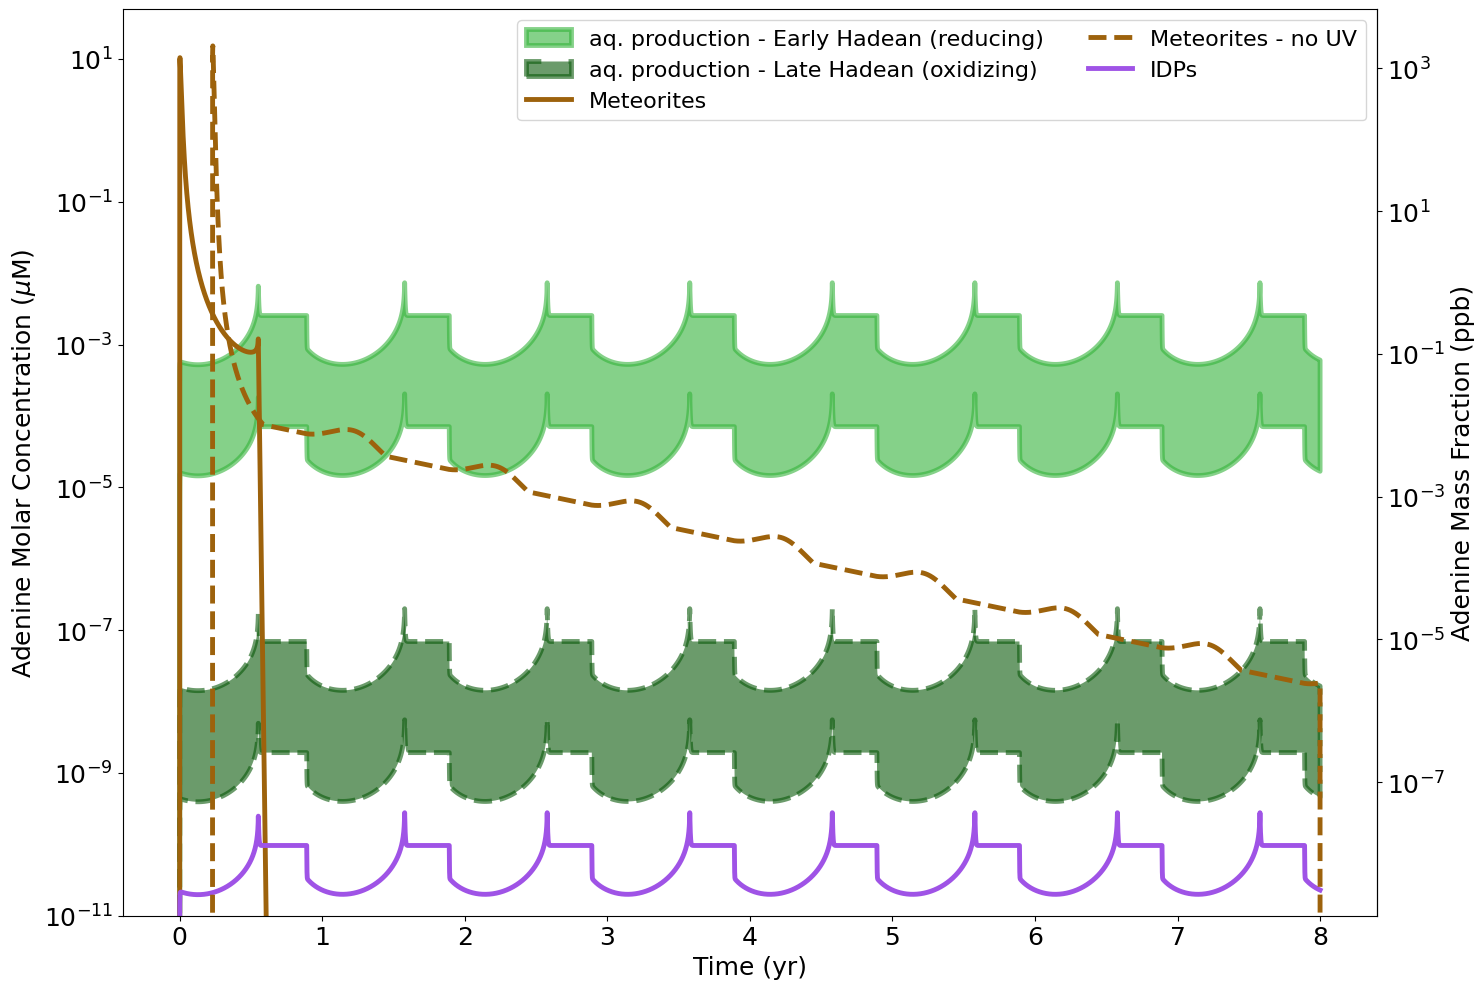

In [20]:

plt.clf()

f, ax1 = plt.subplots(1, 1, figsize=(15,10))
        
p1 = ax1.fill_between(t, C_IDN_Adenine_red*Adenine_lower*1e6/mu_Adenine, C_IDN_Adenine_red*Adenine_upper*1e6/mu_Adenine, linestyle='-', color='#34b33a', lw=3.5, label=r'$\it{in}$ $\it{situ}$ Production - Early Hadean (reducing)', alpha=.60)
         
p2, = ax1.plot(t, C_IDN_Met*1e6/mu_Adenine, linestyle='-', color='#9d620c', lw=3.5, label='Meteorites - Intermediate Env.')
         
p3, = ax1.plot(t, C_IDN_IDP*1e6/mu_Adenine, linestyle='-', color='#9f53e6', lw=3.5, label='IDPs - Intermediate Env.')  
        
p4 = ax1.fill_between(t, C_IDN_Adenine_ox*Adenine_lower*1e6/mu_Adenine, C_IDN_Adenine_ox*Adenine_upper*1e6/mu_Adenine, linestyle='--', color='#095909', lw=3.5, label=r'$\it{in}$ $\it{situ}$ Production - Late Hadean (oxidizing)', alpha=.60)
                        
p5, = ax1.plot(t, C_COL_Met*1e6/mu_Adenine, linestyle='--', color='#9d620c', lw=3.5, label='Meteorites - Wet Env.')      
secax = ax1.secondary_yaxis('right', functions=(molar2mass, mass2molar))

secax.set_ylabel("Adenine Mass Fraction (ppb)",fontsize=18)
#secax.set_yticklabels([1e-7,1e-5,1e-3,1e-1,1e1,1e3],fontsize=18)

ax1.set_ylim(1e-11,50.)

# added labels to points in the curve
# ax1.text(0.222, 0.742, "1", ha="center", size=14, transform=ax1.transAxes, bbox=dict(boxstyle="circle", fc="w", ec="k"))
# ax1.text(0.247, 0.702, "2", ha="center", size=14, transform=ax1.transAxes, bbox=dict(boxstyle="circle", fc="w", ec="k"))
# ax1.text(0.288, 0.647, "3", ha="center", size=14, transform=ax1.transAxes, bbox=dict(boxstyle="circle", fc="w", ec="k"))

ax1.legend([p1,p4,p2,p5,p3], [r'aq. production - Early Hadean (reducing)', r'aq. production - Late Hadean (oxidizing)','Meteorites', 'Meteorites - no UV', 'IDPs',r'Organic Hazes (Early Hadean, 0.5% CH$_4$)'], loc=1,ncol=2, fontsize=16)
ax1.set_yscale('log')

# for tick in ax1.yaxis.get_major_ticks()[::2]:
   # tick.set_visible(False)
ax1.set_xlabel('Time (yr)', fontsize=18)
ax1.set_ylabel('Adenine Molar Concentration ($\mu$M)', fontsize=18)
for tick in ax1.xaxis.get_major_ticks():
    tick.label1.set_fontsize(18) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
    
secax.tick_params(axis='both',labelsize=18)

ax1.text(-1.25, 1.7e1,'', fontsize=30, weight='bold', color='black')


plt.tight_layout()
plt.savefig('Adenine_only_no_haze.png',dpi=300)